# OCS Qubit Readout  Resonator

## To Do:

- [x] Create Metal GUI structure for resonator + transmission line ([Metal GUI](#metal_gui))
- [ ] Scattering Simulation of the resonant structure ([Scattering Simulation](#sim))
- [ ] Calculate $w_{res}$ from simulation ([Simulation Analysis](#ana))

## Questions:

- The simulation conditions don't seem realistic. What changes should I make?


## To Set Up:

1. Parameter sweep of resonator to get required $w_{res} = w^{qubit}_{03}$

# Metal GUI for Resonator
<a id='metal_gui'></a>


In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from qiskit_metal import designs
from qiskit_metal import MetalGUI, Dict

design = designs.DesignPlanar({},True)
gui = MetalGUI(design)

# CHIP SIZE
design._chips['main']['size']['size_x'] = '5mm'
design._chips['main']['size']['size_y'] = '5mm'

# CPW  PARAMETERS: NOT SURE
design.variables['cpw_width'] = '10 um'
design.variables['cpw_gap'] = '6 um'


D:\Users\lfl\Anaconda3\envs\qiskit-metal\lib\site-packages\pyproj\__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [3]:
# enable rebuild of the same component
design.overwrite_enabled = True

In [4]:
# for pins:
from qiskit_metal.qlibrary.terminations.open_to_ground import OpenToGround
# for routing:
from qiskit_metal.qlibrary.tlines.straight_path import RouteStraight
from qiskit_metal.qlibrary.tlines.framed_path import RouteFramed
# for jogs:
from collections import OrderedDict

In [5]:
from qiskit_metal.qlibrary.qubits.transmon_cross_fl import TransmonCrossFL
from qiskit_metal.qlibrary.qubits.transmon_cross import TransmonCross
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander
from qiskit_metal.qlibrary.tlines.anchored_path import RouteAnchors
from qiskit_metal.qlibrary.tlines.pathfinder import RoutePathfinder
from qiskit_metal.qlibrary.terminations.open_to_ground import OpenToGround
from qiskit_metal.qlibrary.terminations.short_to_ground import ShortToGround
from qiskit_metal.qlibrary.terminations.launchpad_wb import LaunchpadWirebond
from qiskit_metal.qlibrary.terminations.launchpad_wb_coupled import LaunchpadWirebondCoupled

## Transmission Line

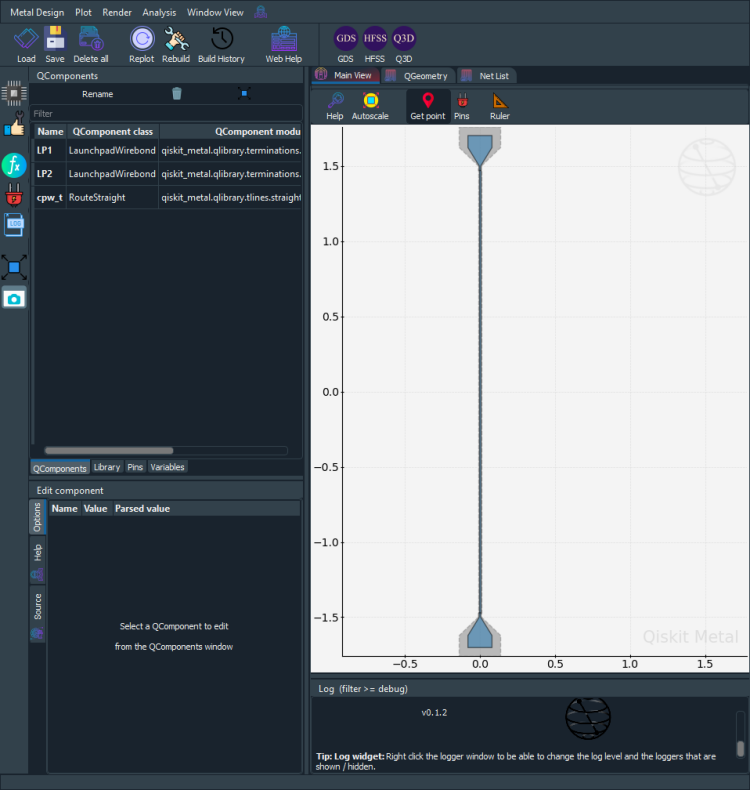

In [6]:
##### TRANSMISSION LINE ######
from qiskit_metal.qlibrary.tlines.straight_path import RouteStraight

lp_num_x_pos = '0um'

launch_options1 = dict(pos_x=lp_num_x_pos, 
                       pos_y= '1500um', 
                       orientation='-90', 
                       lead_length='30um', 
                       pad_width = '160um',
                       pad_length = '200um',
                       trace_width='cpw_width', 
                       trace_gap='cpw_gap')

launch_options2 = dict(pos_x=lp_num_x_pos, 
                       pos_y='-1500um', 
                       orientation='90', 
                       lead_length='30um', 
                       pad_width = '160um',
                       pad_length = '200um',
                       trace_width='cpw_width', 
                       trace_gap='cpw_gap')
options_t = Dict(
        lead=Dict(
            start_straight='0.35mm',
            end_straight='0.3mm'),
        trace_gap='cpw_gap',
        trace_width='cpw_width')

cpw_t_options = {'pin_inputs': {'start_pin': {'component': 'LP1', 'pin': 'tie'},
  'end_pin': {'component': 'LP2', 'pin': 'tie'}},
 'fillet': '0',
 'lead': {'start_straight': '0mm',
  'end_straight': '0mm',
  'start_jogged_extension': '',
  'end_jogged_extension': ''},
 'total_length': '7mm',
 'trace_width': 'cpw_width'}

lp1 = LaunchpadWirebond(design, 'LP1', options = launch_options1)
lp2 = LaunchpadWirebond(design, 'LP2', options = launch_options2)
cpw_t = RouteStraight(design, 'cpw_t', options=cpw_t_options)

gui.rebuild()
gui.autoscale()
gui.screenshot()

## Resonators

In [7]:
# lambda/4 resonators
def add_cpw(total_length = '4.0mm', 
            coupling_length = '180um', 
            finishing_length = '110um',
            pos_x_i = '-30um', 
            pos_y_i = '-1024um',
            pos_x_f = '-1120um', 
            pos_y_f = '-900um',
            index = 1,
            left = True
           ):
    if left:
        otg11 = ShortToGround(design, f'close1i_{index}', 
                             options=dict(
                                          pos_x=pos_x_i,  pos_y=pos_y_i, orientation='-90'))
        otg12 = OpenToGround(design, f'open1o_{index}', 
                             options=dict(
                                          pos_x=pos_x_f,  pos_y=pos_y_f, orientation='180'))
    else:
        otg11 = ShortToGround(design, f'close1i_{index}', 
                                          options=dict(
                                          pos_x=pos_x_i,  pos_y=pos_y_i, orientation='-90'))
        otg12 = OpenToGround(design, f'open1o_{index}', 
                                          options=dict(
                                          pos_x=pos_x_f,  pos_y=pos_y_f, orientation='0'))
    
    
    
    options = Dict(
        pin_inputs=Dict(
            start_pin=Dict(
                component=f'open1o_{index}',
                pin='open'),
            end_pin=Dict(
                component=f'close1i_{index}',
                pin='short')
            ),
            lead=Dict(
                    start_straight=coupling_length,
                    end_straight=finishing_length
            ),
            meander=Dict(
                  spacing = '78um',
                  asymmetry = '0um' #?
            ),
          total_length=total_length,
          trace_gap='6um', #?
          trace_width='10um', #?
          hfss_wire_bonds = False, #?
          fillet='38.5um'
        )


    cpw = RouteMeander(design, f'cpw_{index}', options=options)

    gui.rebuild()
    gui.autoscale()
    gui.screenshot()
    
    return cpw

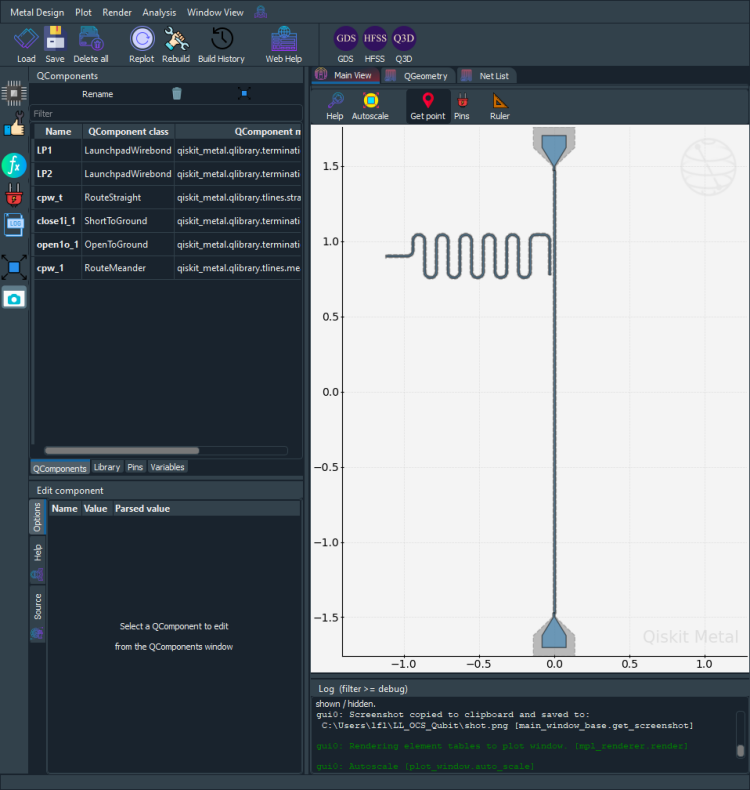

In [8]:
cpw1 = add_cpw(index=1,
                total_length = '3.975mm',
                pos_x_i = '-29um', 
                pos_y_i = '775um',
                pos_x_f = '-1119um', 
                pos_y_f = '900um',
              )

# Simulation: Resonator EPR

<a id='sim'></a>


<font color='red'>NEED HELP WIH OPEN TERMINATION ISSUE and PORT LIST.</font>

In [9]:
from qiskit_metal.analyses.quantization import EPRanalysis

eig_res = EPRanalysis(design, "hfss")

In [10]:
eig_res.sim.setup.max_passes = 18
eig_res.sim.setup.max_delta_f = 0.005
eig_res.sim.setup.n_modes = 1
resistance = 50 # R in signal path

In [11]:
eig_res.setup

{'junctions': {'jj': {'Lj_variable': 'Lj',
   'Cj_variable': 'Cj',
   'rect': '',
   'line': ''}},
 'dissipatives': {'dielectrics_bulk': ['main']},
 'cos_trunc': 8,
 'fock_trunc': 7,
 'sweep_variable': 'Lj'}

In [12]:
hfss = eig_res.sim.renderer

In [13]:
hfss.start()

INFO 03:42PM [connect_project]: Connecting to Ansys Desktop API...
INFO 03:42PM [load_ansys_project]: 	Opened Ansys App
INFO 03:42PM [load_ansys_project]: 	Opened Ansys Desktop v2021.1.0
INFO 03:42PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    D:/Users/lfl/Documents/HFSS/
	Project:   Project40
INFO 03:42PM [connect_design]: 	Opened active design
	Design:    test_res2 [Solution type: Eigenmode]
INFO 03:42PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 03:42PM [connect]: 	Connected to project "Project40" and design "test_res2" 😀 



True

In [14]:
hfss.activate_ansys_design("test_res2", 'eigenmode')  # use new_ansys_design() to force creation of a blank design

INFO 03:42PM [connect_design]: 	Opened active design
	Design:    test_res2 [Solution type: Eigenmode]


In [17]:
hfss.clean_active_design()
hfss.render_design(["LP1","cpw_t","LP2","close1i_1","cpw_1","open1o_1"], [])

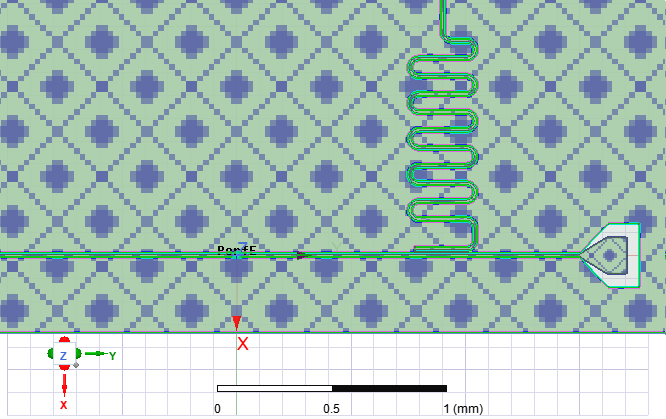

WindowsPath('C:/Users/lfl/LL_OCS_Qubit/ansys.png')

In [18]:
hfss.save_screenshot()

In [20]:
%matplotlib inline

In [19]:
# Analysis properties
setup = hfss.pinfo.setup
print(f"""
Number of eigenmodes to find             = {setup.n_modes}
Number of simulation passes              = {setup.passes}
Convergence freq max delta percent diff  = {setup.delta_f}
""")

# Next 2 lines are counterinuitive, since there is no junction in this resonator.
# However, these are necessary to make pyEPR work correctly. Please do note delete
hfss.pinfo.design.set_variable('Lj', '10 nH')
hfss.pinfo.design.set_variable('Cj', '0 fF')

setup.analyze()

INFO 03:42PM [analyze]: Analyzing setup Setup



Number of eigenmodes to find             = 1
Number of simulation passes              = 10
Convergence freq max delta percent diff  = 0.1



  df = pd.read_csv(io.StringIO(text2[3].strip()),

03:43PM 37s INFO [get_f_convergence]: Saved convergences to C:\Users\lfl\LL_OCS_Qubit\hfss_eig_f_convergence.csv


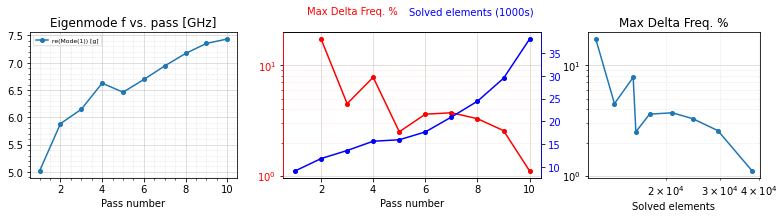

In [21]:
eig_res.sim.convergence_t, eig_res.sim.convergence_f, _ = hfss.get_convergences()
eig_res.sim.plot_convergences()

In [22]:
eig_res.get_frequencies()

Design "test_res2" info:
	# eigenmodes    1
	# variations    1
Design "test_res2" info:
	# eigenmodes    1
	# variations    1


,,Freq. (GHz),Quality Factor
variation,mode,,
0,0,7.43415,inf


03:45PM 07s WARNING [plot_ansys_fields]: This method is deprecated. Change your scripts to use plot_fields()


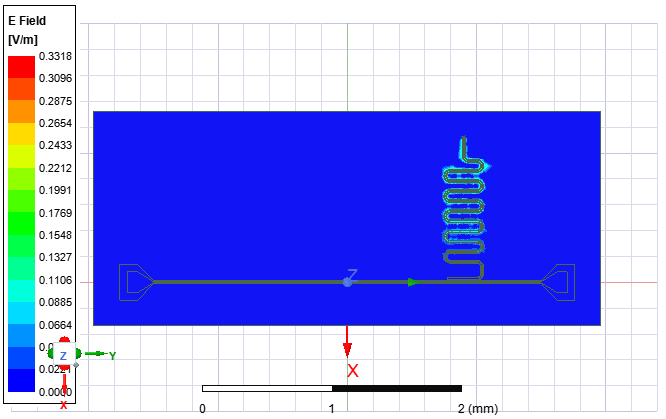

WindowsPath('C:/Users/lfl/LL_OCS_Qubit/ansys.png')

In [23]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()